In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pprint import pprint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GaussianNoise
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
print("x_train shape: {}, y_train shape: {}".format(x_train.shape, y_train.shape))

x_train shape: (60000, 28, 28), y_train shape: (60000,)


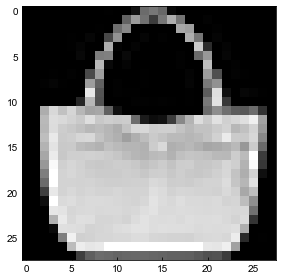

In [4]:
plt.imshow(x_train[100], cmap='gray')

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [6]:
x_train = x_train.reshape(len(x_train), 28*28)
x_val = x_val.reshape(len(x_val), 28*28)
x_test = x_test.reshape(len(x_test), 28*28)

In [7]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)

(54000, 784)
(6000, 784)
(54000,)


In [8]:
x_train = x_train.astype('float32')/255.
x_val = x_val.astype('float32')/255.
x_test = x_test.astype('float32')/255.

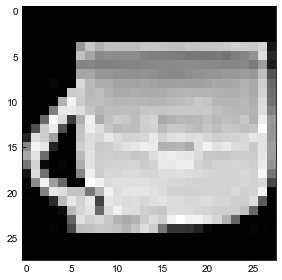

In [9]:
plt.imshow(x_train[10].reshape(28,28), cmap='gray')

In [10]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [11]:
# autoencoder
input_dim = x_train.shape[1]
encoding_dim = y_train.shape[1]
print("Encoding dim: {}".format(encoding_dim))

compression_factor = float(input_dim)/encoding_dim
print("Compression factor: {}".format(compression_factor))

autoencoder = Sequential()
autoencoder.add(Dense(units=4*encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(units=2*encoding_dim, activation='relu'))
autoencoder.add(Dense(units=encoding_dim, activation='relu'))

autoencoder.add(Dense(units=2*encoding_dim, activation='relu'))
autoencoder.add(Dense(units=4*encoding_dim, activation='relu'))
autoencoder.add(Dense(units=input_dim, activation='sigmoid'))

autoencoder.summary()

W0705 14:56:07.928645 23880 deprecation_wrapper.py:119] From C:\Anaconda3\envs\Development\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 14:56:07.946638 23880 deprecation_wrapper.py:119] From C:\Anaconda3\envs\Development\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 14:56:07.950640 23880 deprecation_wrapper.py:119] From C:\Anaconda3\envs\Development\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Encoding dim: 10
Compression factor: 78.4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                31400     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 784)               32144     
Total params: 65,634
Trainable params: 65,634
Non-trainable params: 0
________

In [12]:
# encoder
input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, 
                encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                31400     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 32,430
Trainable params: 32,430
Non-trainable params: 0
_________________________________________________________________


In [13]:
autoencoder.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])

W0705 14:56:14.752967 23880 deprecation_wrapper.py:119] From C:\Anaconda3\envs\Development\lib\site-packages\keras-2.2.4-py3.7.egg\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0705 14:56:14.776973 23880 deprecation_wrapper.py:119] From C:\Anaconda3\envs\Development\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:3645: The name tf.log is deprecated. Please use tf.math.log instead.

W0705 14:56:14.781974 23880 deprecation.py:323] From C:\Anaconda3\envs\Development\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
early_stopping = EarlyStopping(min_delta=1e-4)
hist = autoencoder.fit(x_train, x_train, epochs=100, batch_size=128,
                 validation_data=(x_val, x_val), callbacks=[early_stopping])

W0705 14:56:16.192968 23880 deprecation_wrapper.py:119] From C:\Anaconda3\envs\Development\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:1021: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 5s 84us/step - loss: 0.3984 - acc: 0.4839 - val_loss: 0.3291 - val_acc: 0.5032
Epoch 2/100
54000/54000 [==============================] - 3s 47us/step - loss: 0.3225 - acc: 0.5012 - val_loss: 0.3155 - val_acc: 0.5057
Epoch 3/100
54000/54000 [==============================] - 3s 47us/step - loss: 0.3145 - acc: 0.5029 - val_loss: 0.3105 - val_acc: 0.5066
Epoch 4/100
54000/54000 [==============================] - 3s 48us/step - loss: 0.3101 - acc: 0.5037 - val_loss: 0.3064 - val_acc: 0.5073
Epoch 5/100
54000/54000 [==============================] - 3s 47us/step - loss: 0.3072 - acc: 0.5041 - val_loss: 0.3045 - val_acc: 0.5071
Epoch 6/100
54000/54000 [==============================] - 3s 47us/step - loss: 0.3054 - acc: 0.5044 - val_loss: 0.3027 - val_acc: 0.5079
Epoch 7/100
54000/54000 [==============================] - 3s 47us/step - loss: 0.3037 - acc: 0.5046 - val_loss: 0.3012 - v

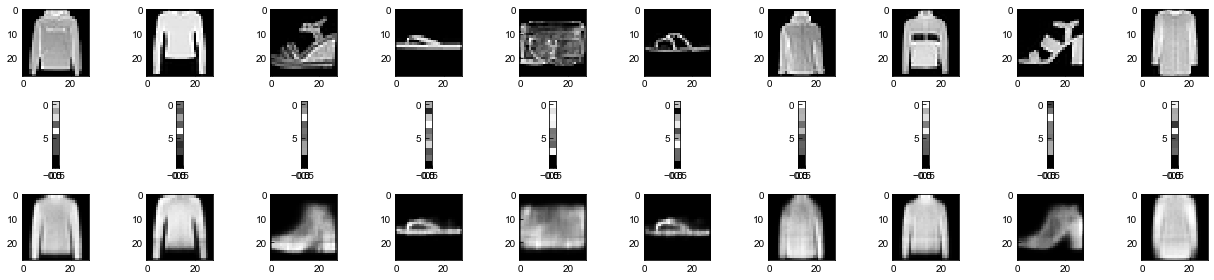

In [16]:
num_images = 10
np.random.seed(2)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i+1)
    plt.imshow(x_test[image_idx].reshape(28,28))
    plt.gray()
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images+i+1)
    plt.imshow(encoded_imgs[image_idx].reshape(10,1))
    plt.gray()
    
    # plot decoded image
    ax = plt.subplot(3, num_images, 2*num_images+i+1)
    plt.imshow(decoded_imgs[image_idx].reshape(28,28))
    plt.gray()

In [17]:
kmeans = KMeans(n_clusters=10)
clustered_training_set = kmeans.fit_predict(encoded_imgs)

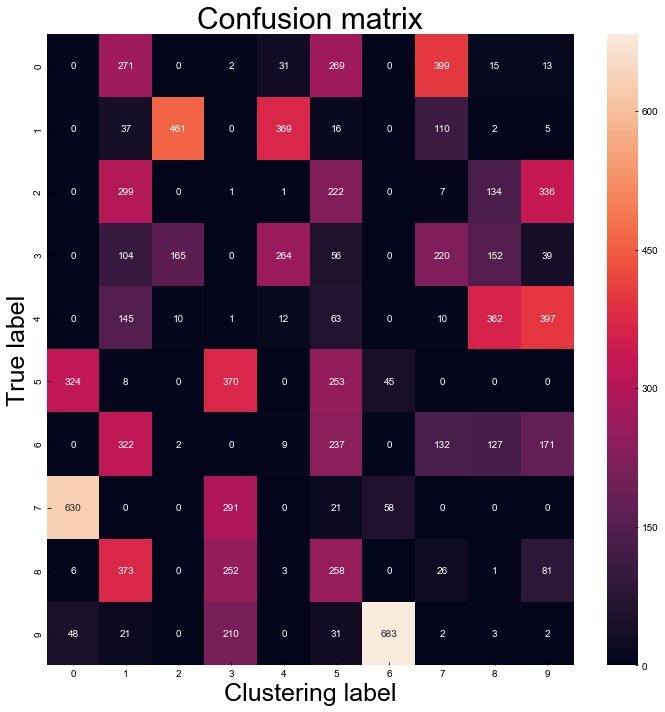

In [18]:
cm = confusion_matrix(y_test, clustered_training_set)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=30)
plt.ylabel("True label", fontsize=25)
plt.xlabel("Clustering label", fontsize=25)
plt.show()

In [19]:
# TSNE
tsne = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encoded_imgs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.719s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.520225
[t-SNE] Computed conditional probabilities in 0.504s
[t-SNE] Iteration 50: error = 93.6119308, gradient norm = 0.0141533 (50 iterations in 6.511s)
[t-SNE] I

In [20]:
print(tsne_results.shape)
print(y_test.shape)
print(y_test)

(10000, 2)
(10000,)
[9 2 1 ... 8 1 5]


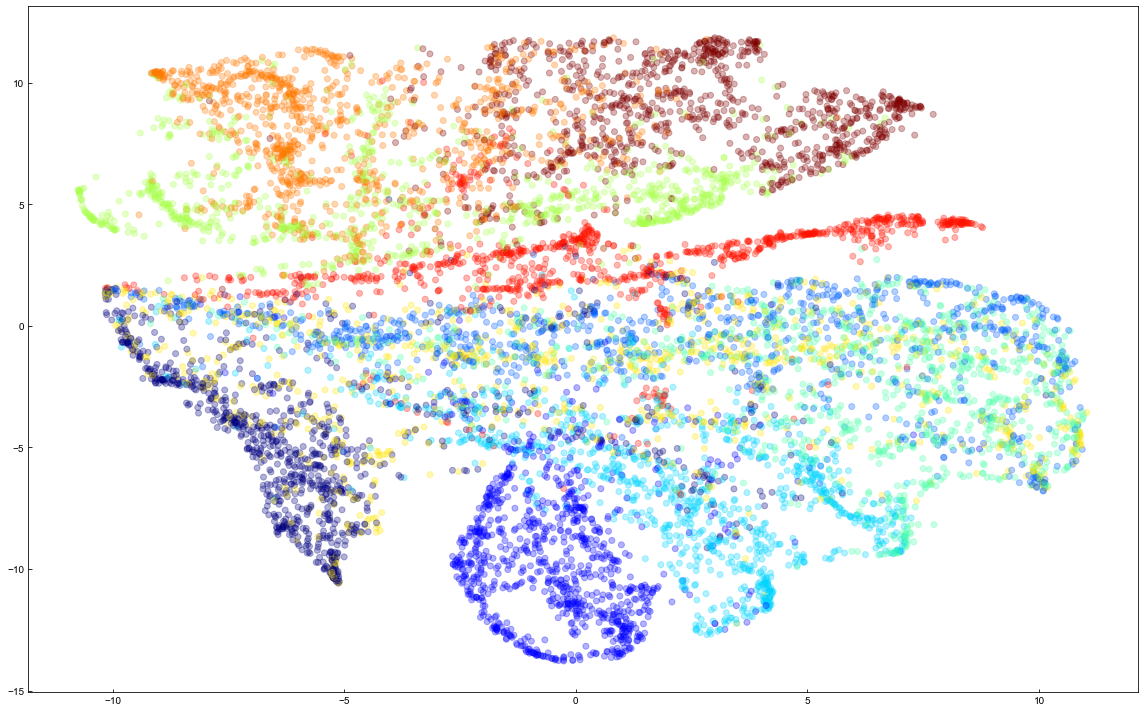

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    alpha=0.3,
    c=y_test,
    cmap='jet'
)
plt.show()